In [109]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
from sklearn.model_selection import train_test_split
import numpy as np
from torchsummary import summary

In [110]:
n_per_cluster  = 1000
img_size = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# initialize tensors containing images and labels
images = torch.zeros(n_per_cluster,1,img_size,img_size)
labels = torch.zeros(n_per_cluster,3)

for i in range(n_per_cluster):

  # location and width parameters
  loc = np.max(x)/2 * np.random.randn(2) # center coordinate
  wid = np.random.rand()*10 + 5 # width of Gaussian

  # create the gaussian with random centers
  G  = np.exp( -( (X-loc[0])**2 + (Y-loc[1])**2) / wid )
  G  = G + np.random.randn(img_size,img_size)/10
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,img_size,img_size)
  labels[i,:] = torch.Tensor( [loc[0],loc[1],wid] )

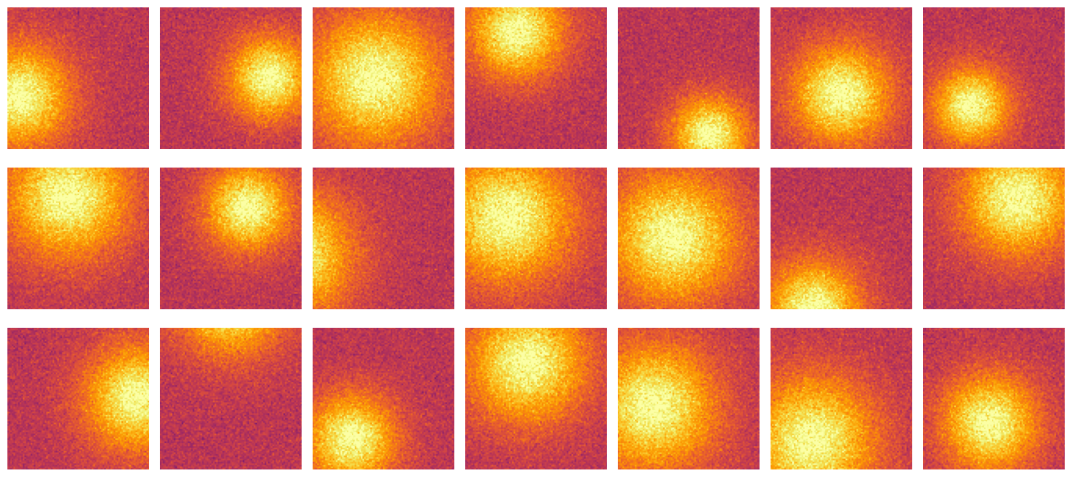

In [111]:
fig, axs = plt.subplots(3, 7, figsize=(15, 7))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[i,:,:,:].permute(1, 2, 0), cmap="inferno", vmax=1, vmin=-1)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [112]:
labels[:21,:]

tensor([[-3.3521e+00,  1.0340e+00,  8.6582e+00],
        [ 2.1753e+00, -1.4320e-02,  5.8210e+00],
        [-5.2979e-01,  5.1646e-02,  1.4398e+01],
        [-1.1200e+00, -2.6456e+00,  7.5079e+00],
        [ 1.1792e+00,  3.2676e+00,  5.0173e+00],
        [-1.8217e-02,  9.4182e-01,  8.1608e+00],
        [-1.3030e+00,  1.6138e+00,  5.0393e+00],
        [-6.3075e-01, -2.3508e+00,  1.2491e+01],
        [ 9.5458e-01, -1.7144e+00,  6.2564e+00],
        [-5.2555e+00,  8.9318e-01,  1.2386e+01],
        [-1.7010e+00, -1.1840e+00,  1.4679e+01],
        [-9.2247e-01, -4.4797e-02,  1.4069e+01],
        [-1.6001e+00,  4.0576e+00,  7.8398e+00],
        [ 1.3152e+00, -2.2363e+00,  1.0856e+01],
        [ 3.3573e+00, -2.4481e-02,  9.1933e+00],
        [ 1.4584e-02, -5.6890e+00,  1.0154e+01],
        [-1.8311e+00,  2.3105e+00,  6.7630e+00],
        [-5.2583e-01, -1.9988e+00,  1.1606e+01],
        [-2.0280e+00,  4.9091e-01,  1.3247e+01],
        [-1.7061e+00,  2.4125e+00,  1.3798e+01],
        [-2.4208e-01

In [113]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=.2)
train_ds = TensorDataset(train_data, train_labels)
test_ds = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_ds, shuffle=True, drop_last=True, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [114]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([16, 1, 91, 91]), torch.Size([16, 3]))

In [115]:
def create_model():
    class GaussParamDetecNet(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, 1, 1), # (91-3+2)/1 + 1 = 91
                nn.ReLU(),
                nn.AvgPool2d(2), # 91//2 = 45
                nn.Conv2d(6, 4, 3, 1, 1), # (45 - 3 + 2)/1 + 1 = 45
                nn.ReLU(),
                nn.AvgPool2d(2), # 45//2 = 22
                nn.Flatten(),
                nn.Linear(22*22*4, 50),
                nn.ReLU(),
                nn.Linear(50, 3)
            )
            
        def forward(self, x):
            return self.enc(x)
    net = GaussParamDetecNet()
    lossfunc = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)
    return net, lossfunc, optimizer

In [116]:
net, lossfunc, _ = create_model()
x = torch.randn(5, 1, img_size, img_size)
y = net(x)
print(y.shape)
loss = lossfunc(y, torch.randn(5, 3))
loss

torch.Size([5, 3])


tensor(0.9603, grad_fn=<MseLossBackward0>)

In [117]:
summary(net, (1, img_size, img_size), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
              ReLU-9                   [-1, 50]               0
           Linear-10                    [-1, 3]             153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.37
Estimated Tot

In [118]:
def train_model():
    epochs = 50
    net, lossfunc, optimizer = create_model()

    train_losses, test_losses = [], []
    for ei in range(epochs):
        net.train()
        batch_loss = []
        for x, y in train_loader:
            y_pred = net(x)
            loss = lossfunc(y_pred, y)
            batch_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_losses.append(np.mean(batch_loss).item())
        net.eval()
        with torch.no_grad():
            x, y = next(iter(test_loader))
            y_test = net(x)
            test_losses.append(lossfunc(y_test, y))
        if (ei + 1)%5 == 0:
            print(f"Epoch: {ei+1}, Train_Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    return train_losses, test_losses, net

In [119]:
train_losses, test_losses, net = train_model()

Epoch: 5, Train_Loss: 0.7875077801942826, Test Loss: 0.7539200782775879
Epoch: 10, Train_Loss: 0.4210528574883938, Test Loss: 0.46299126744270325
Epoch: 15, Train_Loss: 0.3050217853486538, Test Loss: 0.4695272743701935
Epoch: 20, Train_Loss: 0.31027512371540067, Test Loss: 0.3786787986755371
Epoch: 25, Train_Loss: 0.20532224483788014, Test Loss: 0.4506601095199585
Epoch: 30, Train_Loss: 0.16773433454334735, Test Loss: 0.3470957279205322
Epoch: 35, Train_Loss: 0.184358275718987, Test Loss: 0.34965184330940247
Epoch: 40, Train_Loss: 0.12306818827986717, Test Loss: 0.3071786165237427
Epoch: 45, Train_Loss: 0.1285204429551959, Test Loss: 0.2959425151348114
Epoch: 50, Train_Loss: 0.10803693313151598, Test Loss: 0.24773137271404266


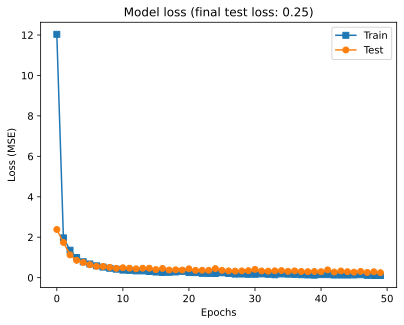

In [120]:
plt.plot(train_losses,'s-',label='Train')
plt.plot(test_losses,'o-',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Model loss (final test loss: %.2f)'%test_losses[-1])

plt.show()

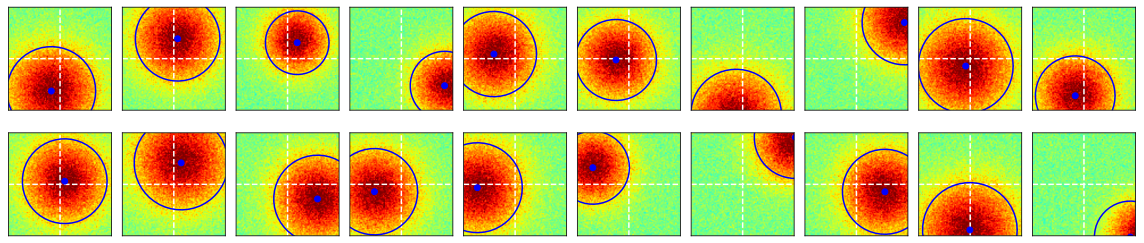

In [121]:
# visualize some images

X,Y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(16,4))

th = np.linspace(0,2*np.pi)

for i,ax in enumerate(axs.flatten()):

  # get the Gaussian and draw it, and draw the white guide-lines
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='lower')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')

  # compute the model's prediction
  cx = yHat[i][0].item() # center X
  cy = yHat[i][1].item() # center Y
  rd = yHat[i][2].item() # radius

  # and draw it
  x = cx + np.cos(th)*np.sqrt(rd)
  y = cy + np.sin(th)*np.sqrt(rd)
  ax.plot(x,y,'b')
  ax.plot(cx,cy,'bo')
  
  # some final plotting niceties
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlim([-4,4])
  ax.set_ylim([-4,4])

plt.tight_layout()
plt.show()

## From Lecture

In [122]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# initialize tensors containing images and labels
images = torch.zeros(nGauss,1,imgSize,imgSize)
labels = torch.zeros(nGauss,3)

for i in range(nGauss):

  # location and width parameters
  loc = np.max(x)/2 * np.random.randn(2) # center coordinate
  wid = np.random.rand()*10 + 5 # width of Gaussian

  # create the gaussian with random centers
  G  = np.exp( -( (X-loc[0])**2 + (Y-loc[1])**2) / wid )
  G  = G + np.random.randn(imgSize,imgSize)/10
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i,:] = torch.Tensor( [loc[0],loc[1],wid] )

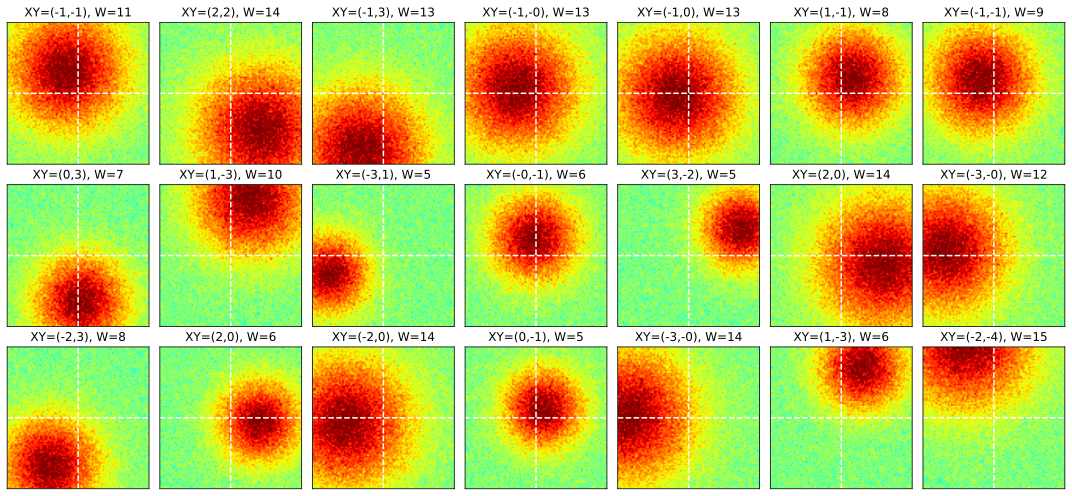

In [123]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,7))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='upper')
  ax.set_title(f'XY=({labels[whichpic,0]:.0f},{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [124]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [125]:
# create a class for the model
def create_lec_model():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(
          
          # conv/pool block 1
          nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   # 
          nn.AvgPool2d(2,2),           # output size: 91/2 = 45
          
          # conv/pool block 2
          nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   # 
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22
          
          # linear decision layer
          nn.Flatten(),                # vectorize conv2 block output
          nn.Linear(22*22*4,50),       # output size: 50
          nn.Linear(50,3),             # output size: 3
      )
      
    def forward(self,x):
      return self.enc(x)
  
  # create the model instance
  net = gausnet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [126]:
# a function that trains the model

def train_lec_model():

  # number of epochs
  numepochs = 30
  
  # create a new model
  net,lossfun,optimizer = create_lec_model()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # extract the loss for this test epoch
    testLoss[epochi] = loss.item()

  # end epochs

  # function output
  return trainLoss,testLoss,net

In [127]:
train_losses, test_losses, net = train_lec_model()

In [128]:
train_losses[-1]

tensor(0.4032)

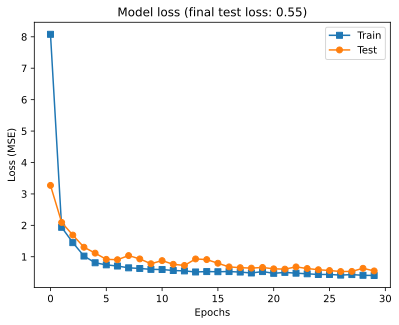

In [129]:
plt.plot(train_losses,'s-',label='Train')
plt.plot(test_losses,'o-',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Model loss (final test loss: %.2f)'%test_losses[-1])

plt.show()

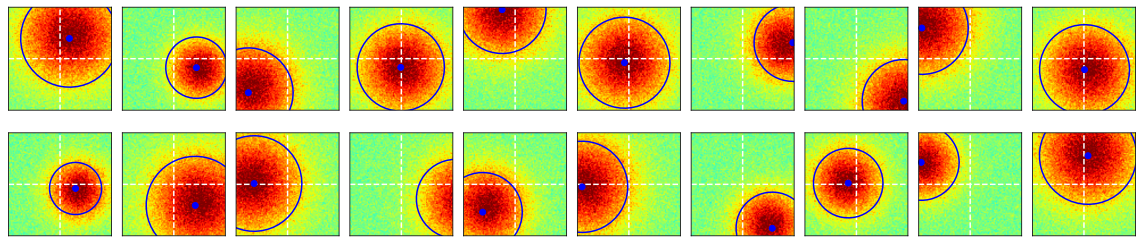

In [130]:
# visualize some images

X,Y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(16,4))

th = np.linspace(0,2*np.pi)

for i,ax in enumerate(axs.flatten()):

  # get the Gaussian and draw it, and draw the white guide-lines
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='lower')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')

  # compute the model's prediction
  cx = yHat[i][0].item() # center X
  cy = yHat[i][1].item() # center Y
  rd = yHat[i][2].item() # radius

  # and draw it
  x = cx + np.cos(th)*np.sqrt(rd)
  y = cy + np.sin(th)*np.sqrt(rd)
  ax.plot(x,y,'b')
  ax.plot(cx,cy,'bo')
  
  # some final plotting niceties
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlim([-4,4])
  ax.set_ylim([-4,4])

plt.tight_layout()
plt.show()